<a href="https://colab.research.google.com/github/xqyn/modeling/blob/main/kl_divergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, pearsonr

X = np.array([0.1, 0.15, 0.05, 0.2, 0.1, 0.08, 0.12, 0.07, 0.08, 0.05])
Y = np.array([0.12, 0.13, 0.06, 0.18, 0.11, 0.09, 0.11, 0.08, 0.07, 0.05])

# Jensen-Shannon Divergence (returns distance, not divergence)
jsd = jensenshannon(X, Y)  # squared JS divergence
js_distance = jensenshannon(X, Y, base=2)

# KL Divergence
kl_div = entropy(X, Y)

# Hellinger distance
hellinger = np.sqrt(np.sum((np.sqrt(X) - np.sqrt(Y))**2)) / np.sqrt(2)

# Total Variation Distance
tv_distance = 0.5 * np.sum(np.abs(X - Y))

# Cosine similarity
cosine_sim = np.dot(X, Y) / (np.linalg.norm(X) * np.linalg.norm(Y))

# Pearson correlation
pearson_corr, _ = pearsonr(X, Y)

print(f"Jensen-Shannon Distance: {js_distance:.4f}")
print(f"KL Divergence: {kl_div:.4f}")
print(f"Hellinger Distance: {hellinger:.4f}")
print(f"Total Variation Distance: {tv_distance:.4f}")
print(f"Cosine Similarity: {cosine_sim:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")

Jensen-Shannon Distance: 0.0539
KL Divergence: 0.0080
Hellinger Distance: 0.0449
Total Variation Distance: 0.0600
Cosine Similarity: 0.9926
Pearson Correlation: 0.9626


Probability Distributions:
           Element_1  Element_2  Element_3  Element_4  Element_5  Element_6  \
Sample_1       0.046      0.293      0.128      0.089      0.017      0.017   
Sample_2       0.005      0.000      0.400      0.053      0.045      0.045   
Sample_3       0.156      0.082      0.002      0.389      0.113      0.066   
Sample_4       0.000      0.078      0.020      0.000      0.146      0.275   
Sample_5       0.047      0.035      0.083      0.016      0.172      0.008   
Sample_6       0.219      0.159      0.169      0.191      0.010      0.057   
Sample_7       0.086      0.050      0.371      0.196      0.133      0.000   
Sample_8       0.089      0.074      0.022      0.274      0.087      0.113   
Sample_9       0.104      0.042      0.092      0.366      0.067      0.022   
Sample_10      0.309      0.082      0.073      0.048      0.065      0.214   

           Element_7  Element_8  Element_9  Element_10  
Sample_1       0.006      0.196      0.089    

/tmp/ipython-input-2996456839.py:148: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(jsd_matrix, method='average')


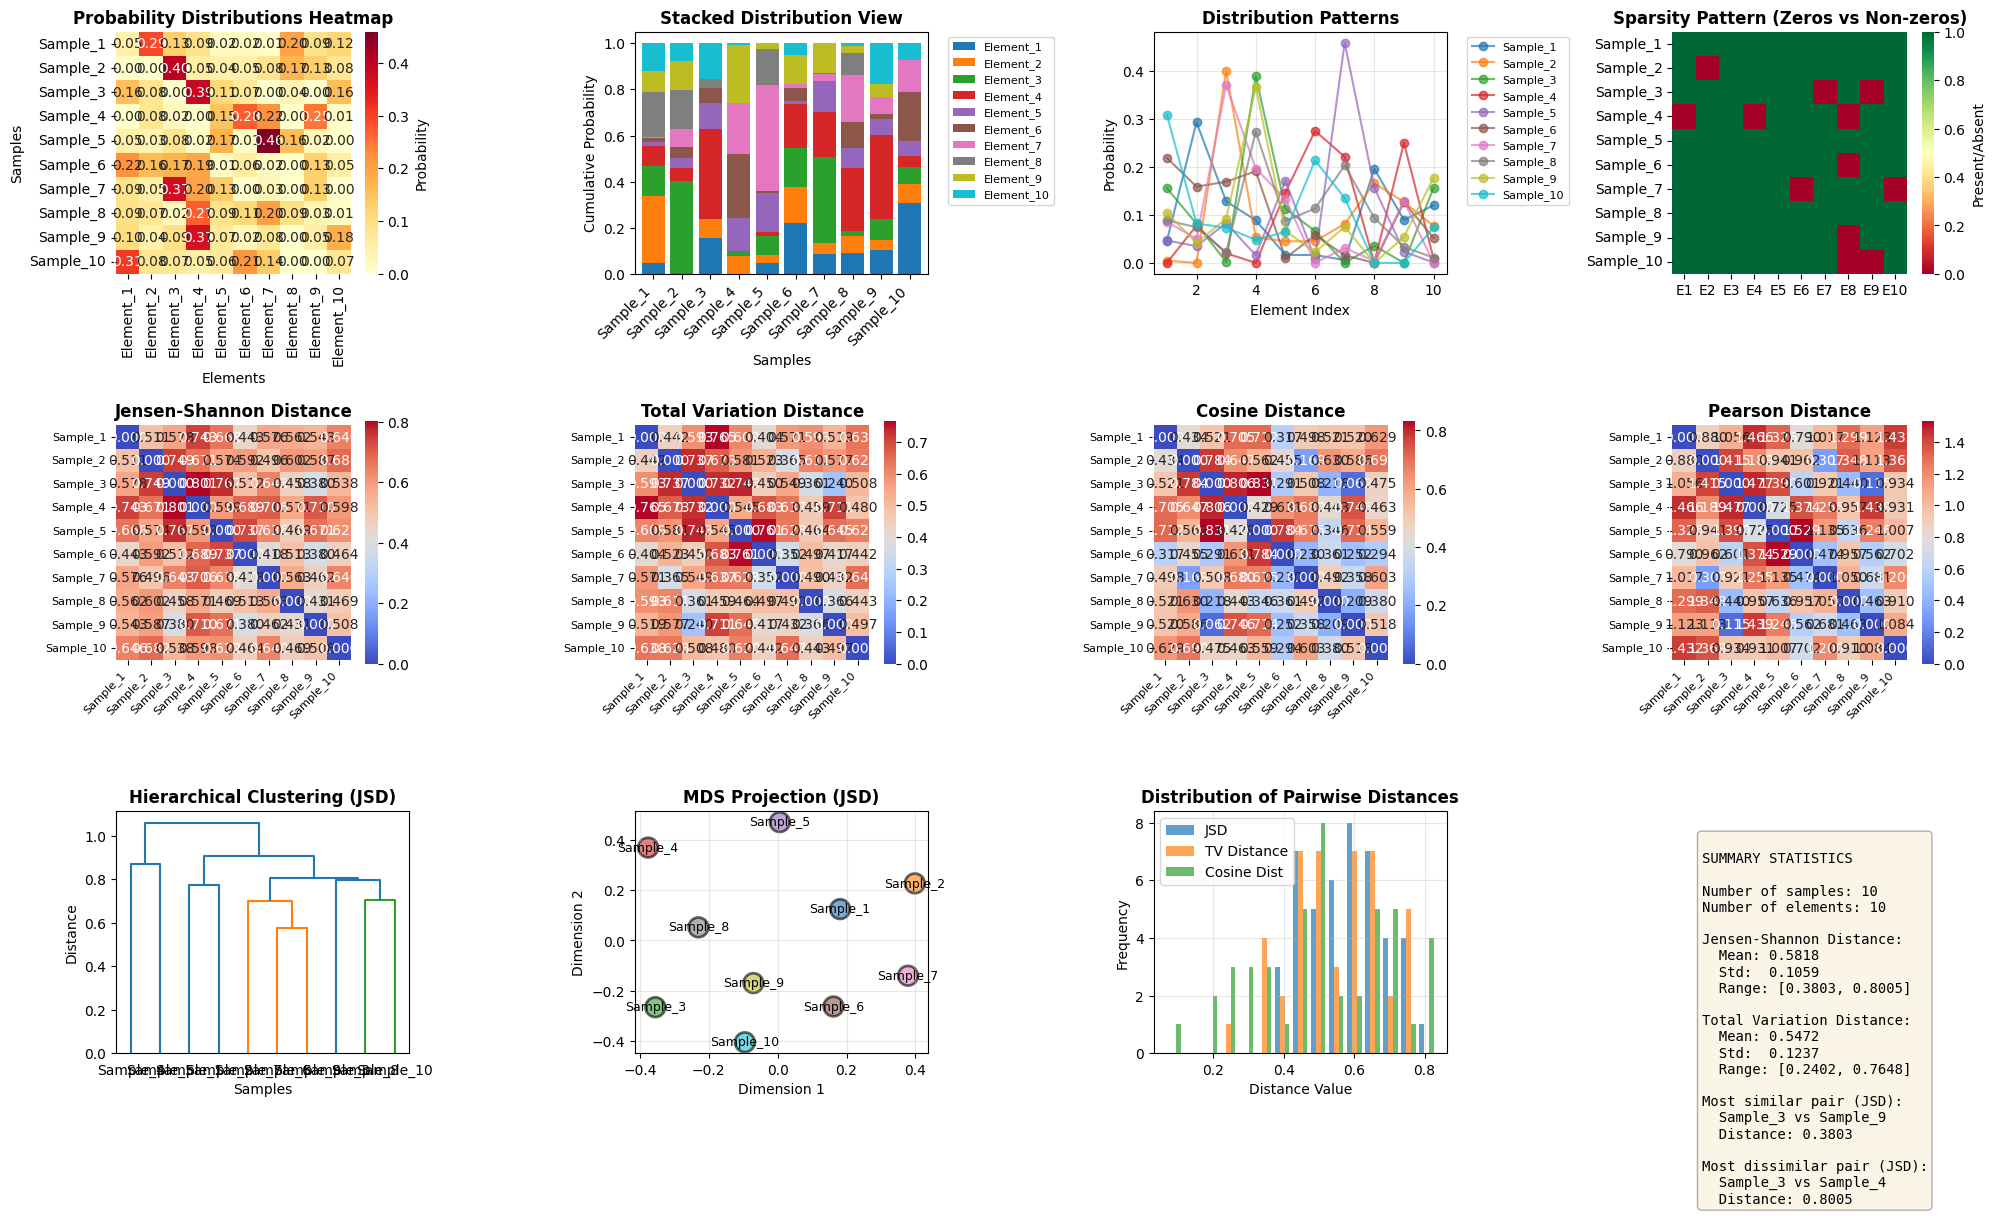


Saved jensen_shannon_distance.csv

Saved total_variation_distance.csv

Saved cosine_distance.csv

Saved pearson_distance.csv

✓ Visualization saved as 'probability_distributions_comparison.png'
✓ Distance matrices saved as CSV files


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import MDS

# Set random seed for reproducibility
np.random.seed(42)

# Generate 10 probability distributions (some with zeros)
def generate_prob_dist(n_elements=10, sparsity=0):
    """Generate a probability distribution with optional zeros"""
    probs = np.random.dirichlet(np.ones(n_elements))
    if sparsity > 0:
        # Set some elements to zero
        zero_indices = np.random.choice(n_elements, size=int(n_elements * sparsity), replace=False)
        probs[zero_indices] = 0
        # Renormalize
        if probs.sum() > 0:
            probs = probs / probs.sum()
    return probs

# Create 10 distributions with varying sparsity
distributions = {
    'Sample_1': generate_prob_dist(sparsity=0),
    'Sample_2': generate_prob_dist(sparsity=0.1),
    'Sample_3': generate_prob_dist(sparsity=0.2),
    'Sample_4': generate_prob_dist(sparsity=0.3),
    'Sample_5': generate_prob_dist(sparsity=0),
    'Sample_6': generate_prob_dist(sparsity=0.1),
    'Sample_7': generate_prob_dist(sparsity=0.2),
    'Sample_8': generate_prob_dist(sparsity=0),
    'Sample_9': generate_prob_dist(sparsity=0.15),
    'Sample_10': generate_prob_dist(sparsity=0.25),
}

# Convert to DataFrame
df_dists = pd.DataFrame(distributions).T
df_dists.columns = [f'Element_{i+1}' for i in range(10)]

print("Probability Distributions:")
print(df_dists.round(3))
print(f"\nSum check (should all be 1.0): {df_dists.sum(axis=1).values}")

# ============================================
# Calculate pairwise distances/similarities
# ============================================

sample_names = list(distributions.keys())
n_samples = len(sample_names)

# Initialize distance matrices
jsd_matrix = np.zeros((n_samples, n_samples))
tv_matrix = np.zeros((n_samples, n_samples))
cosine_matrix = np.zeros((n_samples, n_samples))
pearson_matrix = np.zeros((n_samples, n_samples))

# Calculate all pairwise metrics
for i, name1 in enumerate(sample_names):
    for j, name2 in enumerate(sample_names):
        X = distributions[name1]
        Y = distributions[name2]

        # Add small pseudocount to avoid log(0) issues in KL/JSD
        X_smooth = X + 1e-10
        Y_smooth = Y + 1e-10
        X_smooth = X_smooth / X_smooth.sum()
        Y_smooth = Y_smooth / Y_smooth.sum()

        # Jensen-Shannon Distance
        jsd_matrix[i, j] = jensenshannon(X_smooth, Y_smooth, base=2)

        # Total Variation Distance
        tv_matrix[i, j] = 0.5 * np.sum(np.abs(X - Y))

        # Cosine Similarity (convert to distance)
        cosine_sim = np.dot(X, Y) / (np.linalg.norm(X) * np.linalg.norm(Y) + 1e-10)
        cosine_matrix[i, j] = 1 - cosine_sim  # Convert to distance

        # Pearson Correlation (convert to distance)
        if np.std(X) > 0 and np.std(Y) > 0:
            corr, _ = pearsonr(X, Y)
            pearson_matrix[i, j] = 1 - corr  # Convert to distance
        else:
            pearson_matrix[i, j] = 1

# ============================================
# Visualization
# ============================================

fig = plt.figure(figsize=(20, 12))

# 1. Heatmap of probability distributions
ax1 = plt.subplot(3, 4, 1)
sns.heatmap(df_dists, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Probability'})
ax1.set_title('Probability Distributions Heatmap', fontsize=12, fontweight='bold')
ax1.set_xlabel('Elements')
ax1.set_ylabel('Samples')

# 2. Stacked bar plot
ax2 = plt.subplot(3, 4, 2)
df_dists.plot(kind='bar', stacked=True, ax=ax2, colormap='tab10', width=0.8)
ax2.set_title('Stacked Distribution View', fontsize=12, fontweight='bold')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Cumulative Probability')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Line plot showing patterns
ax3 = plt.subplot(3, 4, 3)
for sample in sample_names:
    ax3.plot(range(1, 11), distributions[sample], marker='o', label=sample, alpha=0.7)
ax3.set_title('Distribution Patterns', fontsize=12, fontweight='bold')
ax3.set_xlabel('Element Index')
ax3.set_ylabel('Probability')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Sparsity pattern
ax4 = plt.subplot(3, 4, 4)
binary_matrix = (df_dists > 0).astype(int)
sns.heatmap(binary_matrix, cmap='RdYlGn', cbar_kws={'label': 'Present/Absent'},
            yticklabels=sample_names, xticklabels=[f'E{i+1}' for i in range(10)])
ax4.set_title('Sparsity Pattern (Zeros vs Non-zeros)', fontsize=12, fontweight='bold')

# 5-8. Distance matrices
distance_matrices = {
    'Jensen-Shannon Distance': jsd_matrix,
    'Total Variation Distance': tv_matrix,
    'Cosine Distance': cosine_matrix,
    'Pearson Distance': pearson_matrix
}

for idx, (title, matrix) in enumerate(distance_matrices.items(), start=5):
    ax = plt.subplot(3, 4, idx)
    sns.heatmap(matrix, annot=True, fmt='.3f', cmap='coolwarm',
                xticklabels=sample_names, yticklabels=sample_names,
                vmin=0, vmax=matrix.max(), square=True)
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

# 9. Hierarchical clustering (using JSD)
ax9 = plt.subplot(3, 4, 9)
linkage_matrix = linkage(jsd_matrix, method='average')
dendrogram(linkage_matrix, labels=sample_names, ax=ax9, leaf_font_size=10)
ax9.set_title('Hierarchical Clustering (JSD)', fontsize=12, fontweight='bold')
ax9.set_xlabel('Samples')
ax9.set_ylabel('Distance')

# 10. MDS plot (2D projection using JSD)
ax10 = plt.subplot(3, 4, 10)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(jsd_matrix)
scatter = ax10.scatter(coords[:, 0], coords[:, 1], s=200, c=range(n_samples),
                       cmap='tab10', alpha=0.6, edgecolors='black', linewidth=2)
for i, name in enumerate(sample_names):
    ax10.annotate(name, (coords[i, 0], coords[i, 1]),
                 fontsize=9, ha='center', va='center')
ax10.set_title('MDS Projection (JSD)', fontsize=12, fontweight='bold')
ax10.set_xlabel('Dimension 1')
ax10.set_ylabel('Dimension 2')
ax10.grid(True, alpha=0.3)

# 11. Distribution of distances
ax11 = plt.subplot(3, 4, 11)
# Get upper triangle of matrices (excluding diagonal)
mask = np.triu(np.ones_like(jsd_matrix, dtype=bool), k=1)
jsd_values = jsd_matrix[mask]
tv_values = tv_matrix[mask]
cosine_values = cosine_matrix[mask]

ax11.hist([jsd_values, tv_values, cosine_values],
         label=['JSD', 'TV Distance', 'Cosine Dist'],
         bins=15, alpha=0.7)
ax11.set_title('Distribution of Pairwise Distances', fontsize=12, fontweight='bold')
ax11.set_xlabel('Distance Value')
ax11.set_ylabel('Frequency')
ax11.legend()
ax11.grid(True, alpha=0.3)

# 12. Summary statistics
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')

summary_text = f"""
SUMMARY STATISTICS

Number of samples: {n_samples}
Number of elements: {df_dists.shape[1]}

Jensen-Shannon Distance:
  Mean: {jsd_values.mean():.4f}
  Std:  {jsd_values.std():.4f}
  Range: [{jsd_values.min():.4f}, {jsd_values.max():.4f}]

Total Variation Distance:
  Mean: {tv_values.mean():.4f}
  Std:  {tv_values.std():.4f}
  Range: [{tv_values.min():.4f}, {tv_values.max():.4f}]

Most similar pair (JSD):
"""

# Find most similar pair
min_idx = np.unravel_index(np.argmin(jsd_matrix + np.eye(n_samples) * 999), jsd_matrix.shape)
summary_text += f"  {sample_names[min_idx[0]]} vs {sample_names[min_idx[1]]}\n"
summary_text += f"  Distance: {jsd_matrix[min_idx]:.4f}\n\n"

# Find most dissimilar pair
max_idx = np.unravel_index(np.argmax(jsd_matrix), jsd_matrix.shape)
summary_text += f"Most dissimilar pair (JSD):\n"
summary_text += f"  {sample_names[max_idx[0]]} vs {sample_names[max_idx[1]]}\n"
summary_text += f"  Distance: {jsd_matrix[max_idx]:.4f}"

ax12.text(0.1, 0.9, summary_text, transform=ax12.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('probability_distributions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# Export distance matrices to CSV
# ============================================

for name, matrix in distance_matrices.items():
    df_matrix = pd.DataFrame(matrix, index=sample_names, columns=sample_names)
    filename = name.lower().replace(' ', '_').replace('-', '_') + '.csv'
    df_matrix.to_csv(filename)
    print(f"\nSaved {filename}")

print("\n✓ Visualization saved as 'probability_distributions_comparison.png'")
print("✓ Distance matrices saved as CSV files")

In [9]:
df_dists.iloc[1,:]

,Sample_2
Element_1,0.004658
Element_2,0.000000
Element_3,0.400038
Element_4,0.053450
Element_5,0.044938
Element_6,0.045371
Element_7,0.081232
Element_8,0.166589
Element_9,0.126642
Element_10,0.077082


In [12]:

df_dists.iloc[2,:] = df_dists.iloc[1,:]

In [13]:
df_dists

,Element_1,Element_2,Element_3,Element_4,Element_5,Element_6,Element_7,Element_8,Element_9,Element_10
Sample_1,0.045694,0.293107,0.128217,0.088897,0.016517,0.016514,0.005827,0.195841,0.089495,0.119892
Sample_2,0.004658,0.000000,0.400038,0.053450,0.044938,0.045371,0.081232,0.166589,0.126642,0.077082
Sample_3,0.004658,0.000000,0.400038,0.053450,0.044938,0.045371,0.081232,0.166589,0.126642,0.077082
Sample_4,0.000000,0.077668,0.020063,0.000000,0.146482,0.275355,0.221077,0.000000,0.250259,0.009095
Sample_5,0.046720,0.034922,0.082847,0.016084,0.171589,0.008204,0.458931,0.156659,0.023458,0.000586
Sample_6,0.218900,0.158951,0.169128,0.191091,0.009965,0.057499,0.015952,0.000000,0.126465,0.052049
Sample_7,0.085651,0.050193,0.370685,0.196492,0.132994,0.000000,0.030755,0.004291,0.128939,0.000000
Sample_8,0.088677,0.074218,0.021703,0.273676,0.087344,0.113475,0.203112,0.093622,0.033511,0.010660
Sample_9,0.103942,0.042011,0.091829,0.366134,0.066831,0.022195,0.075089,0.000000,0.054143,0.177826
Sample_10,0.308540,0.082143,0.073239,0.048221,0.064603,0.213708,0.135352,0.000000,0.000000,0.074193


In [15]:
print(df_dists.round(3))

           Element_1  Element_2  Element_3  Element_4  Element_5  Element_6  \
Sample_1       0.046      0.293      0.128      0.089      0.017      0.017   
Sample_2       0.005      0.000      0.400      0.053      0.045      0.045   
Sample_3       0.005      0.000      0.400      0.053      0.045      0.045   
Sample_4       0.000      0.078      0.020      0.000      0.146      0.275   
Sample_5       0.047      0.035      0.083      0.016      0.172      0.008   
Sample_6       0.219      0.159      0.169      0.191      0.010      0.057   
Sample_7       0.086      0.050      0.371      0.196      0.133      0.000   
Sample_8       0.089      0.074      0.022      0.274      0.087      0.113   
Sample_9       0.104      0.042      0.092      0.366      0.067      0.022   
Sample_10      0.309      0.082      0.073      0.048      0.065      0.214   

           Element_7  Element_8  Element_9  Element_10  
Sample_1       0.006      0.196      0.089       0.120  
Sample_2       0

Probability Distributions:
           Element_1  Element_2  Element_3  Element_4  Element_5  Element_6  \
Sample_1       0.046      0.293      0.128      0.089      0.017      0.017   
Sample_2       0.005      0.000      0.400      0.053      0.045      0.045   
Sample_3       0.005      0.000      0.400      0.053      0.045      0.045   
Sample_4       0.000      0.078      0.020      0.000      0.146      0.275   
Sample_5       0.047      0.035      0.083      0.016      0.172      0.008   
Sample_6       0.219      0.159      0.169      0.191      0.010      0.057   
Sample_7       0.086      0.050      0.371      0.196      0.133      0.000   
Sample_8       0.089      0.074      0.022      0.274      0.087      0.113   
Sample_9       0.104      0.042      0.092      0.366      0.067      0.022   
Sample_10      0.309      0.082      0.073      0.048      0.065      0.214   

           Element_7  Element_8  Element_9  Element_10  
Sample_1       0.006      0.196      0.089    

/tmp/ipython-input-2399806313.py:105: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(jsd_matrix, method='average')


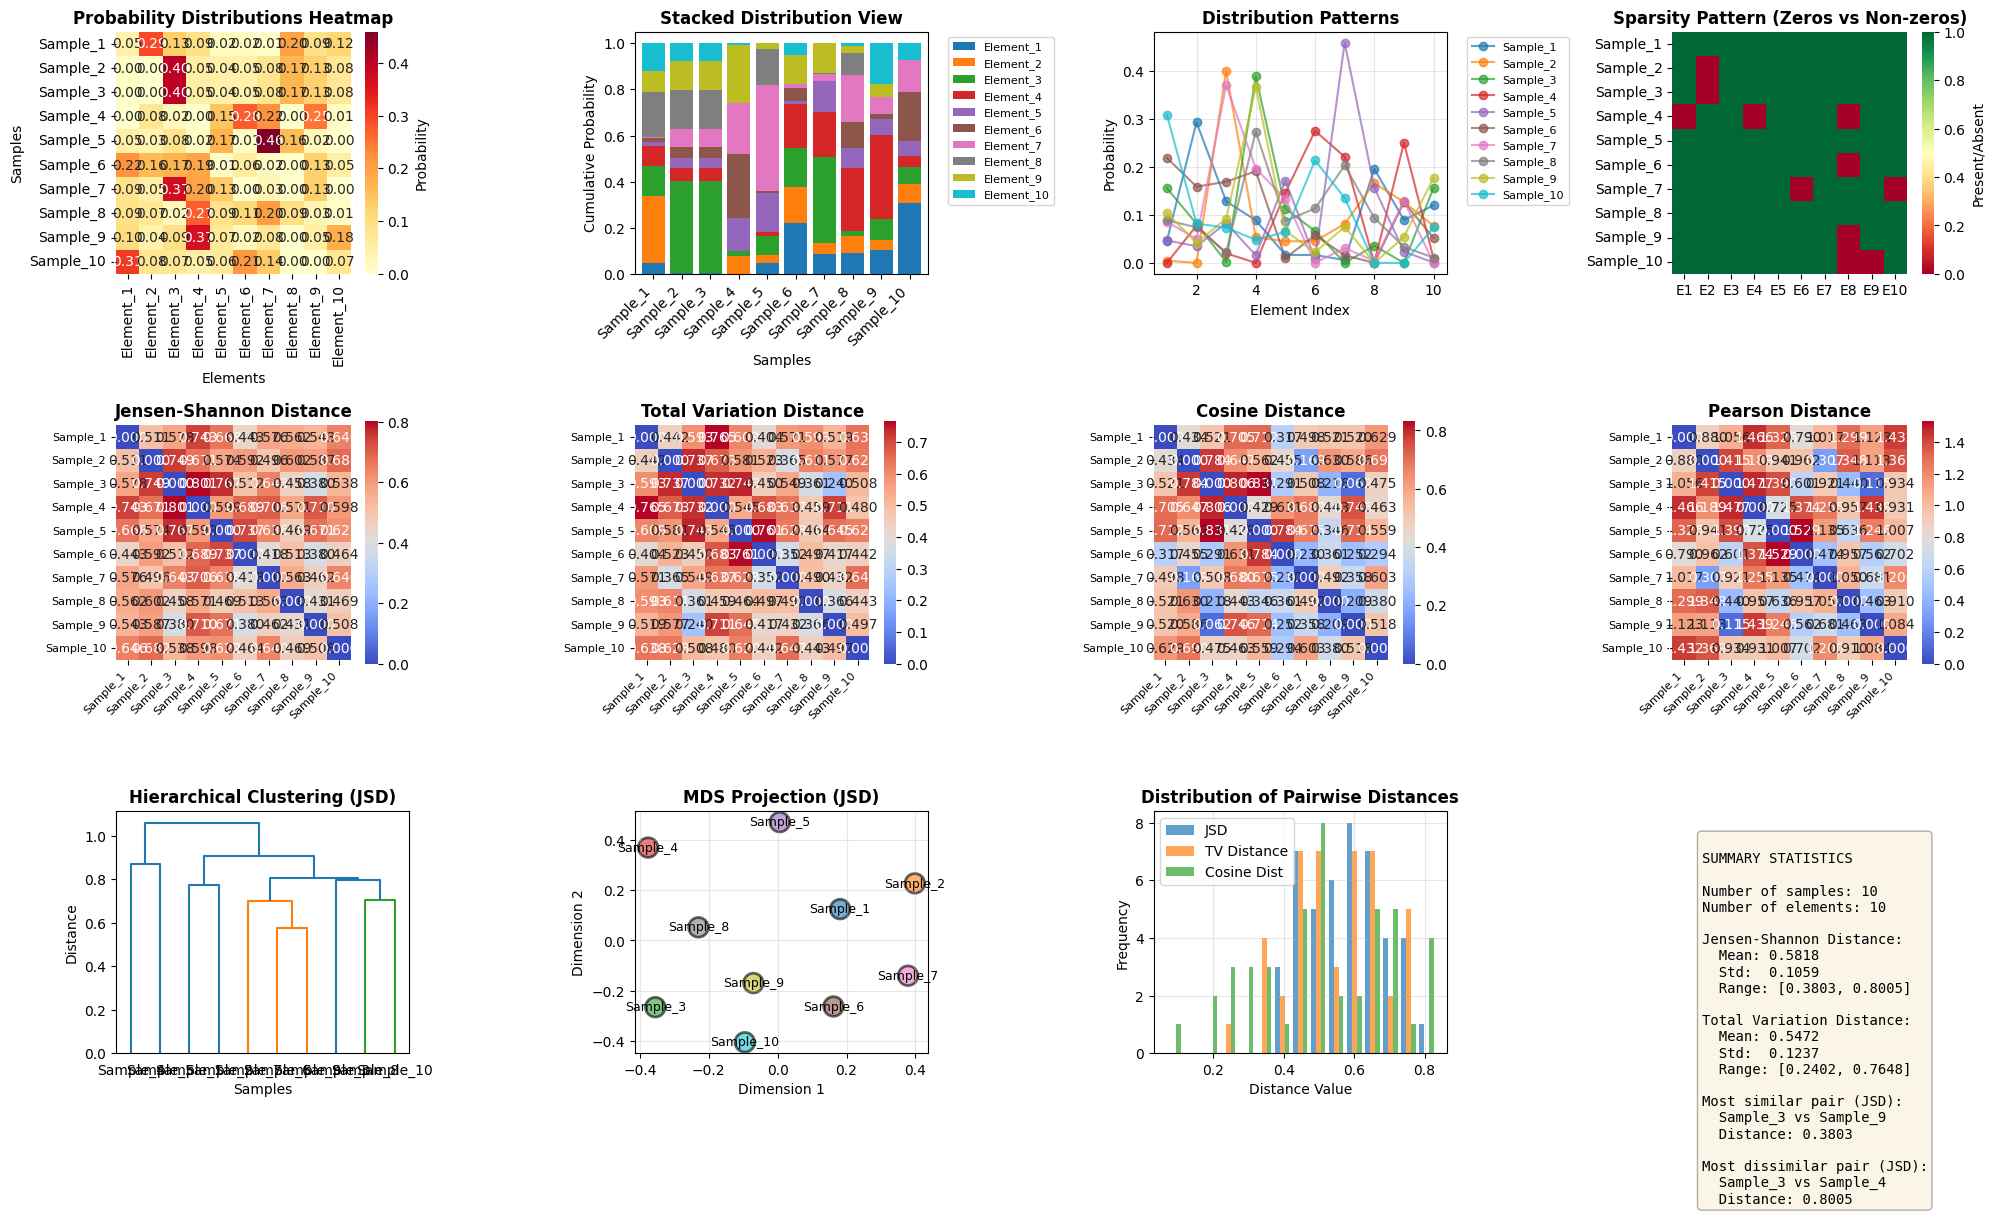


Saved jensen_shannon_distance.csv

Saved total_variation_distance.csv

Saved cosine_distance.csv

Saved pearson_distance.csv

✓ Visualization saved as 'probability_distributions_comparison.png'
✓ Distance matrices saved as CSV files


In [14]:

print("Probability Distributions:")
print(df_dists.round(3))
print(f"\nSum check (should all be 1.0): {df_dists.sum(axis=1).values}")

# ============================================
# Calculate pairwise distances/similarities
# ============================================

sample_names = list(distributions.keys())
n_samples = len(sample_names)

# Initialize distance matrices
jsd_matrix = np.zeros((n_samples, n_samples))
tv_matrix = np.zeros((n_samples, n_samples))
cosine_matrix = np.zeros((n_samples, n_samples))
pearson_matrix = np.zeros((n_samples, n_samples))

# Calculate all pairwise metrics
for i, name1 in enumerate(sample_names):
    for j, name2 in enumerate(sample_names):
        X = distributions[name1]
        Y = distributions[name2]

        # Add small pseudocount to avoid log(0) issues in KL/JSD
        X_smooth = X + 1e-10
        Y_smooth = Y + 1e-10
        X_smooth = X_smooth / X_smooth.sum()
        Y_smooth = Y_smooth / Y_smooth.sum()

        # Jensen-Shannon Distance
        jsd_matrix[i, j] = jensenshannon(X_smooth, Y_smooth, base=2)

        # Total Variation Distance
        tv_matrix[i, j] = 0.5 * np.sum(np.abs(X - Y))

        # Cosine Similarity (convert to distance)
        cosine_sim = np.dot(X, Y) / (np.linalg.norm(X) * np.linalg.norm(Y) + 1e-10)
        cosine_matrix[i, j] = 1 - cosine_sim  # Convert to distance

        # Pearson Correlation (convert to distance)
        if np.std(X) > 0 and np.std(Y) > 0:
            corr, _ = pearsonr(X, Y)
            pearson_matrix[i, j] = 1 - corr  # Convert to distance
        else:
            pearson_matrix[i, j] = 1

# ============================================
# Visualization
# ============================================

fig = plt.figure(figsize=(20, 12))

# 1. Heatmap of probability distributions
ax1 = plt.subplot(3, 4, 1)
sns.heatmap(df_dists, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Probability'})
ax1.set_title('Probability Distributions Heatmap', fontsize=12, fontweight='bold')
ax1.set_xlabel('Elements')
ax1.set_ylabel('Samples')

# 2. Stacked bar plot
ax2 = plt.subplot(3, 4, 2)
df_dists.plot(kind='bar', stacked=True, ax=ax2, colormap='tab10', width=0.8)
ax2.set_title('Stacked Distribution View', fontsize=12, fontweight='bold')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Cumulative Probability')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Line plot showing patterns
ax3 = plt.subplot(3, 4, 3)
for sample in sample_names:
    ax3.plot(range(1, 11), distributions[sample], marker='o', label=sample, alpha=0.7)
ax3.set_title('Distribution Patterns', fontsize=12, fontweight='bold')
ax3.set_xlabel('Element Index')
ax3.set_ylabel('Probability')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Sparsity pattern
ax4 = plt.subplot(3, 4, 4)
binary_matrix = (df_dists > 0).astype(int)
sns.heatmap(binary_matrix, cmap='RdYlGn', cbar_kws={'label': 'Present/Absent'},
            yticklabels=sample_names, xticklabels=[f'E{i+1}' for i in range(10)])
ax4.set_title('Sparsity Pattern (Zeros vs Non-zeros)', fontsize=12, fontweight='bold')

# 5-8. Distance matrices
distance_matrices = {
    'Jensen-Shannon Distance': jsd_matrix,
    'Total Variation Distance': tv_matrix,
    'Cosine Distance': cosine_matrix,
    'Pearson Distance': pearson_matrix
}

for idx, (title, matrix) in enumerate(distance_matrices.items(), start=5):
    ax = plt.subplot(3, 4, idx)
    sns.heatmap(matrix, annot=True, fmt='.3f', cmap='coolwarm',
                xticklabels=sample_names, yticklabels=sample_names,
                vmin=0, vmax=matrix.max(), square=True)
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

# 9. Hierarchical clustering (using JSD)
ax9 = plt.subplot(3, 4, 9)
linkage_matrix = linkage(jsd_matrix, method='average')
dendrogram(linkage_matrix, labels=sample_names, ax=ax9, leaf_font_size=10)
ax9.set_title('Hierarchical Clustering (JSD)', fontsize=12, fontweight='bold')
ax9.set_xlabel('Samples')
ax9.set_ylabel('Distance')

# 10. MDS plot (2D projection using JSD)
ax10 = plt.subplot(3, 4, 10)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(jsd_matrix)
scatter = ax10.scatter(coords[:, 0], coords[:, 1], s=200, c=range(n_samples),
                       cmap='tab10', alpha=0.6, edgecolors='black', linewidth=2)
for i, name in enumerate(sample_names):
    ax10.annotate(name, (coords[i, 0], coords[i, 1]),
                 fontsize=9, ha='center', va='center')
ax10.set_title('MDS Projection (JSD)', fontsize=12, fontweight='bold')
ax10.set_xlabel('Dimension 1')
ax10.set_ylabel('Dimension 2')
ax10.grid(True, alpha=0.3)

# 11. Distribution of distances
ax11 = plt.subplot(3, 4, 11)
# Get upper triangle of matrices (excluding diagonal)
mask = np.triu(np.ones_like(jsd_matrix, dtype=bool), k=1)
jsd_values = jsd_matrix[mask]
tv_values = tv_matrix[mask]
cosine_values = cosine_matrix[mask]

ax11.hist([jsd_values, tv_values, cosine_values],
         label=['JSD', 'TV Distance', 'Cosine Dist'],
         bins=15, alpha=0.7)
ax11.set_title('Distribution of Pairwise Distances', fontsize=12, fontweight='bold')
ax11.set_xlabel('Distance Value')
ax11.set_ylabel('Frequency')
ax11.legend()
ax11.grid(True, alpha=0.3)

# 12. Summary statistics
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')

summary_text = f"""
SUMMARY STATISTICS

Number of samples: {n_samples}
Number of elements: {df_dists.shape[1]}

Jensen-Shannon Distance:
  Mean: {jsd_values.mean():.4f}
  Std:  {jsd_values.std():.4f}
  Range: [{jsd_values.min():.4f}, {jsd_values.max():.4f}]

Total Variation Distance:
  Mean: {tv_values.mean():.4f}
  Std:  {tv_values.std():.4f}
  Range: [{tv_values.min():.4f}, {tv_values.max():.4f}]

Most similar pair (JSD):
"""

# Find most similar pair
min_idx = np.unravel_index(np.argmin(jsd_matrix + np.eye(n_samples) * 999), jsd_matrix.shape)
summary_text += f"  {sample_names[min_idx[0]]} vs {sample_names[min_idx[1]]}\n"
summary_text += f"  Distance: {jsd_matrix[min_idx]:.4f}\n\n"

# Find most dissimilar pair
max_idx = np.unravel_index(np.argmax(jsd_matrix), jsd_matrix.shape)
summary_text += f"Most dissimilar pair (JSD):\n"
summary_text += f"  {sample_names[max_idx[0]]} vs {sample_names[max_idx[1]]}\n"
summary_text += f"  Distance: {jsd_matrix[max_idx]:.4f}"

ax12.text(0.1, 0.9, summary_text, transform=ax12.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('probability_distributions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# Export distance matrices to CSV
# ============================================

for name, matrix in distance_matrices.items():
    df_matrix = pd.DataFrame(matrix, index=sample_names, columns=sample_names)
    filename = name.lower().replace(' ', '_').replace('-', '_') + '.csv'
    df_matrix.to_csv(filename)
    print(f"\nSaved {filename}")

print("\n✓ Visualization saved as 'probability_distributions_comparison.png'")
print("✓ Distance matrices saved as CSV files")

In [36]:
X = df_dists.iloc[1,:]
Y = df_dists.iloc[8,:]

# Jensen-Shannon Divergence (returns distance, not divergence)
jsd = jensenshannon(X, Y)  # squared JS divergence
js_distance = jensenshannon(X, Y, base=2)

# KL Divergence
kl_div = entropy(X, Y)

# Hellinger distance
hellinger = np.sqrt(np.sum((np.sqrt(X) - np.sqrt(Y))**2)) / np.sqrt(2)

# Total Variation Distance
tv_distance = 0.5 * np.sum(np.abs(X - Y))

# Cosine similarity
cosine_sim = np.dot(X, Y) / (np.linalg.norm(X) * np.linalg.norm(Y))

# Pearson correlation
pearson_corr, _ = pearsonr(X, Y)

print(f"Jensen-Shannon Distance: {js_distance:.4f}")
print(f"KL Divergence: {kl_div:.4f}")
print(f"Hellinger Distance: {hellinger:.4f}")
print(f"Total Variation Distance: {tv_distance:.4f}")
print(f"Cosine Similarity: {cosine_sim:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")

Jensen-Shannon Distance: 0.5868
KL Divergence: inf
Hellinger Distance: 0.5310
Total Variation Distance: 0.5766
Cosine Similarity: 0.4136
Pearson Correlation: -0.1128


In [18]:
df_dists.iloc[1,:]

,Sample_3
Element_1,0.004658
Element_2,0.000000
Element_3,0.400038
Element_4,0.053450
Element_5,0.044938
Element_6,0.045371
Element_7,0.081232
Element_8,0.166589
Element_9,0.126642
Element_10,0.077082


In [37]:
import numpy as np

def safe_kl_divergence(P, Q, epsilon=1e-10):
    """
    Compute KL divergence D(P || Q) safely, avoiding issues with zeros.

    Parameters:
        P (array-like): True probability distribution
        Q (array-like): Approximate probability distribution
        epsilon (float): Small value to avoid log(0)

    Returns:
        float: KL divergence
    """
    P = np.array(P, dtype=np.float64)
    Q = np.array(Q, dtype=np.float64)

    # Add epsilon to avoid division by zero or log(0)
    P = np.clip(P, epsilon, 1)
    Q = np.clip(Q, epsilon, 1)

    # Normalize in case clipping changed the sums
    P /= P.sum()
    Q /= Q.sum()

    # Compute KL divergence
    kl = np.sum(P * np.log(P / Q))
    return kl

# Example usage
P = [0.5, 0.5, 0.0]
Q = [0.9, 0.1, 0.0]

kl = safe_kl_divergence(P, Q)
print("KL Divergence:", kl)


KL Divergence: 0.5108256237149081


In [39]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, pearsonr

# Function to compute all metrics for a pair of vectors
def compute_metrics(X, Y):
    # Jensen-Shannon distance
    js_distance = jensenshannon(X, Y, base=2)

    # KL Divergence
    kl_div = entropy(X, Y)

    # Hellinger distance
    hellinger = np.sqrt(np.sum((np.sqrt(X) - np.sqrt(Y))**2)) / np.sqrt(2)

    # Total Variation Distance
    tv_distance = 0.5 * np.sum(np.abs(X - Y))

    # Cosine similarity
    cosine_sim = np.dot(X, Y) / (np.linalg.norm(X) * np.linalg.norm(Y))

    # Pearson correlation
    pearson_corr, _ = pearsonr(X, Y)

    return js_distance, kl_div, hellinger, tv_distance, cosine_sim, pearson_corr

# Select rows 1 to 10
rows = df_dists.iloc[1:11, :]

# Create an empty list to store results
results = []

# Iterate over all pairs
for i in range(len(rows)):
    for j in range(i+1, len(rows)):
        X = rows.iloc[i, :]
        Y = rows.iloc[j, :]
        metrics = compute_metrics(X, Y)
        results.append([i+1, j+1, *metrics])  # store row indices and metrics

# Convert to DataFrame
metrics_df = pd.DataFrame(
    results,
    columns=[
        'Row1', 'Row2',
        'Jensen-Shannon Distance', 'KL Divergence', 'Hellinger Distance',
        'Total Variation Distance', 'Cosine Similarity', 'Pearson Correlation'
    ]
)

# Display the table
print(metrics_df)


    Row1  Row2  Jensen-Shannon Distance  KL Divergence  Hellinger Distance  \
0      1     2                 0.000000       0.000000            0.000000   
1      1     3                 0.671483            inf            0.615623   
2      1     4                 0.574225       1.159902            0.500918   
3      1     5                 0.592374            inf            0.555667   
4      1     6                 0.495955            inf            0.458967   
5      1     7                 0.601828       1.335694            0.532920   
6      1     8                 0.586804            inf            0.530963   
7      1     9                 0.682293            inf            0.638220   
8      2     3                 0.671483            inf            0.615623   
9      2     4                 0.574225       1.159902            0.500918   
10     2     5                 0.592374            inf            0.555667   
11     2     6                 0.495955            inf          

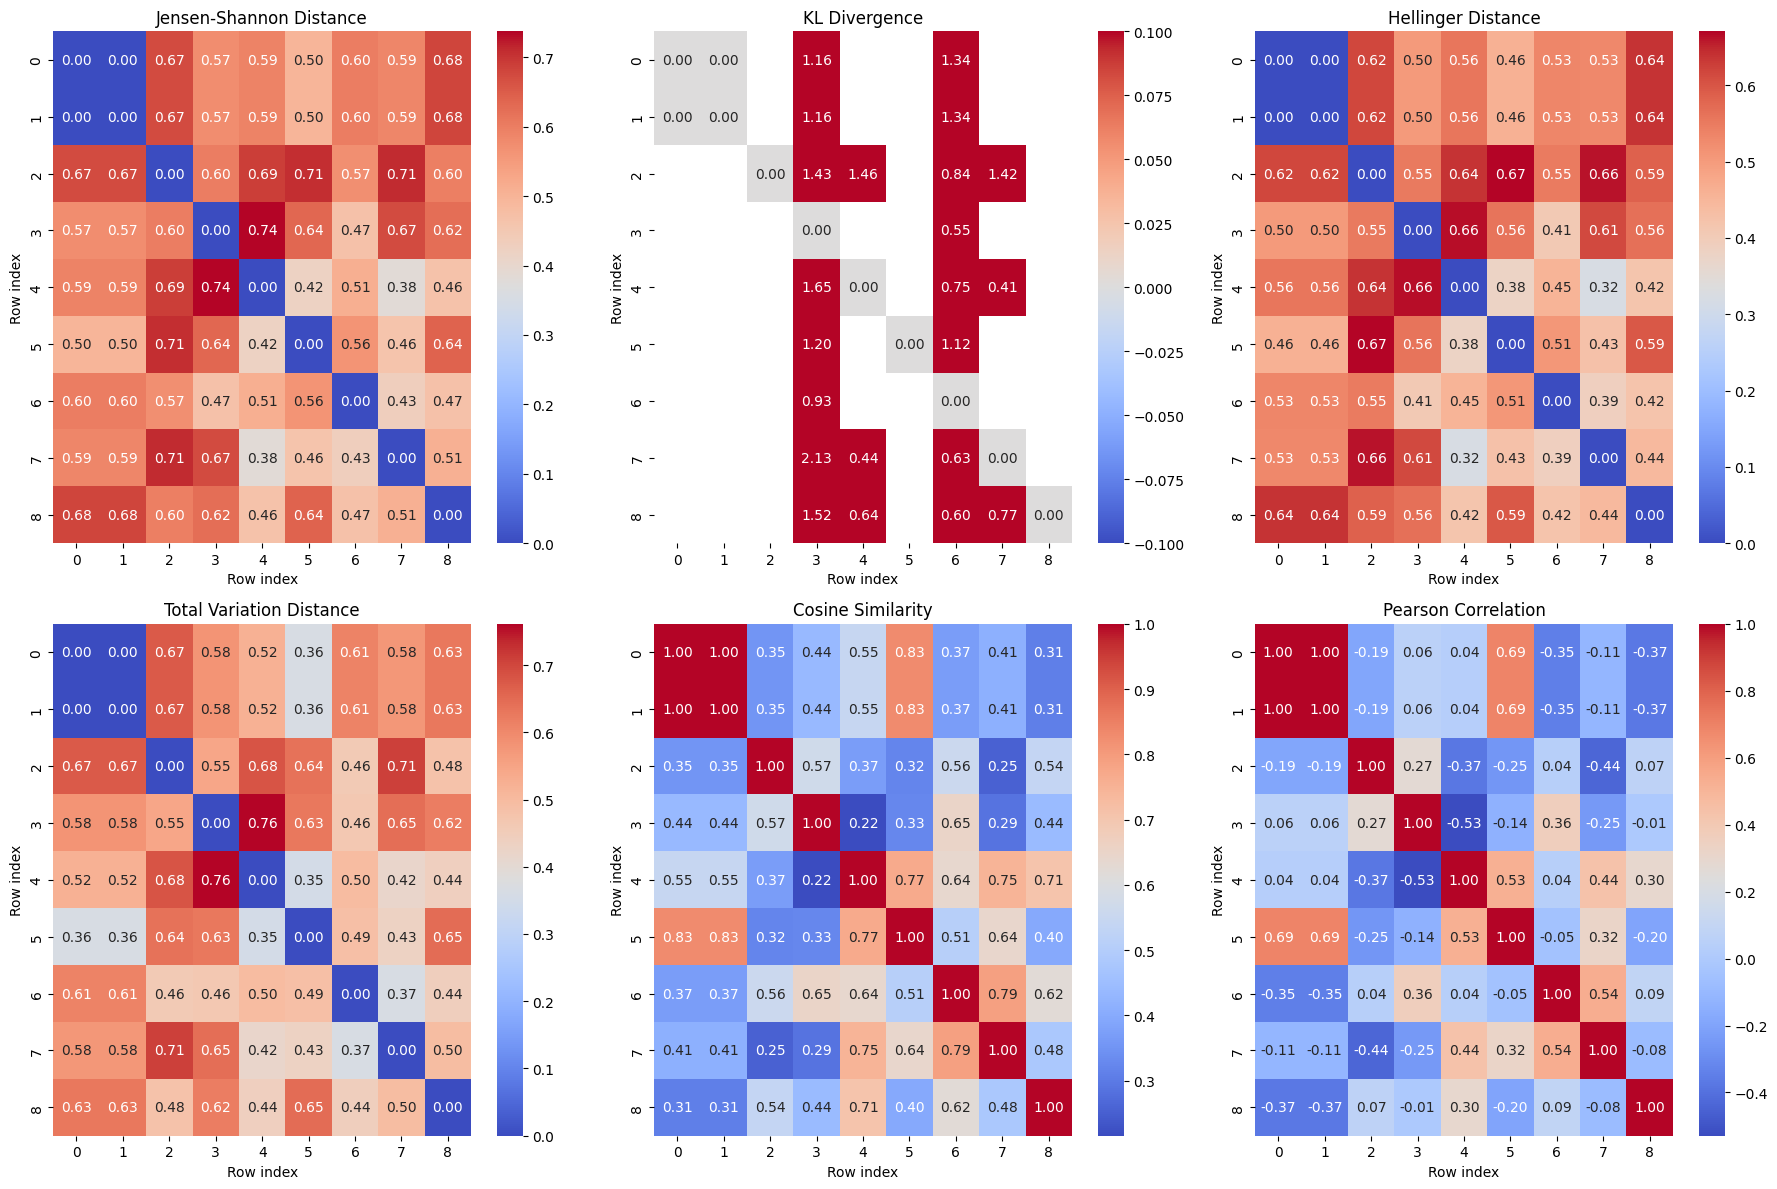

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, pearsonr

# Function to compute all metrics for a pair of vectors
def compute_metrics(X, Y):
    js_distance = jensenshannon(X, Y, base=2)
    kl_div = entropy(X, Y)
    hellinger = np.sqrt(np.sum((np.sqrt(X) - np.sqrt(Y))**2)) / np.sqrt(2)
    tv_distance = 0.5 * np.sum(np.abs(X - Y))
    cosine_sim = np.dot(X, Y) / (np.linalg.norm(X) * np.linalg.norm(Y))
    pearson_corr, _ = pearsonr(X, Y)
    return js_distance, kl_div, hellinger, tv_distance, cosine_sim, pearson_corr

# Select rows 1 to 10
rows = df_dists.iloc[1:11, :]

n = len(rows)

# Initialize empty matrices for each metric
js_matrix = np.zeros((n, n))
kl_matrix = np.zeros((n, n))
hellinger_matrix = np.zeros((n, n))
tv_matrix = np.zeros((n, n))
cosine_matrix = np.zeros((n, n))
pearson_matrix = np.zeros((n, n))

# Compute metrics for all pairs
for i in range(n):
    for j in range(n):
        X = rows.iloc[i, :]
        Y = rows.iloc[j, :]
        js, kl, hell, tv, cos, pear = compute_metrics(X, Y)
        js_matrix[i,j] = js
        kl_matrix[i,j] = kl
        hellinger_matrix[i,j] = hell
        tv_matrix[i,j] = tv
        cosine_matrix[i,j] = cos
        pearson_matrix[i,j] = pear

# Plot heatmaps
metrics = {
    "Jensen-Shannon Distance": js_matrix,
    "KL Divergence": kl_matrix,
    "Hellinger Distance": hellinger_matrix,
    "Total Variation Distance": tv_matrix,
    "Cosine Similarity": cosine_matrix,
    "Pearson Correlation": pearson_matrix
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for ax, (name, matrix) in zip(axes, metrics.items()):
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Row index")
    ax.set_ylabel("Row index")

plt.tight_layout()
plt.show()
